# Question B.1

This notebook documents the development a time series for the optimal portfolio decision $\alpha_t(k)$.

## Libraries

For our calculations, we want to import the following libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg

## Data Loading

We first want to load in our predicted returns data, along with the other dataframes we've generated so far. 

In [2]:
#Read in augmented data
aug_df = pd.read_csv('../data/augmented_data_A2.csv', index_col = [0], parse_dates = True)

#Read in returns
returns = pd.read_csv('../data/predicted_returns_A2.csv')

#Read in original data
df = pd.read_csv('../data/data.csv', index_col = [0], parse_dates = True)

We next merge the two dataframes, which allows us to find the Sigma column again which will be useful in this part.

In [3]:
#Merge augmented data and the sigma portion of the original data frame, by date
aug_df = aug_df.merge(df[['date', 'Sigma']], 'inner', 'date') 

We now convert the date to datetime format. Like before, we use a period in the data of a day since the observations are almost daily.

In [4]:
#Set date as the index
aug_df.set_index('date', inplace = True)

#'Periodise' the data by days
aug_df.index = pd.DatetimeIndex(aug_df.index).to_period('D')

We now inspect our dataframe to this point.

In [5]:
#Print head of data
aug_df.head()

,Return_with_Dividends,Return_without_Dividends,RiskFree_Rate_1Month_Forward,Return_1Month_Forward,PD_t,delta_d,Predicted R_t,Sigma
date,,,,,,,,
1998-02-07,0.304277,0.143167,0.350638,0.055277,7.095540,0.303119,0.078501,NaN
1998-02-10,0.291903,0.154534,0.363007,0.025068,8.404637,0.303119,0.078501,NaN
1998-02-11,0.269282,0.179072,0.365795,0.043227,13.070375,0.585262,0.078501,NaN
1998-02-12,0.290409,0.160366,0.377143,0.056165,8.922924,-0.216997,0.078501,NaN
1998-02-13,0.268346,0.149079,0.350271,0.074432,9.634514,0.225464,0.078501,NaN


## Data Augmentation

Since there are many NaN values in the Sigma category, we need to impute the values we do not observe.

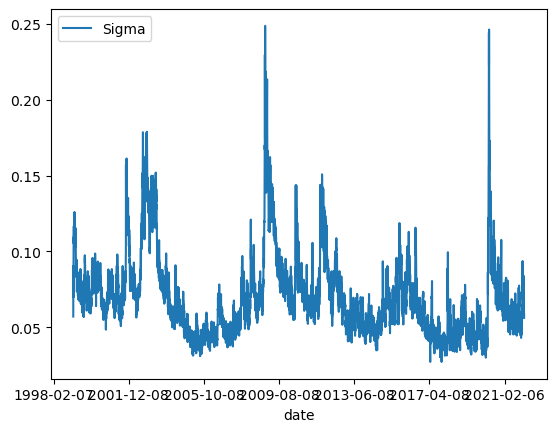

In [6]:
df.plot(x='date', y='Sigma')
plt.show()

We observe that most sigma values fall in a certain range, and over the whole time frame it is reasonably stationary. We check this mathematically with the ADF test.

In [7]:
#Calculate ADF Statistic
sigma_adf = adfuller(aug_df["Sigma"].dropna())

#Print Statistic
print('ADF Statistic: %f' % sigma_adf[0])

#Print p-value for testing
print('p-value: %f' % sigma_adf[1])

#Print critical values
print('Critical Values:')
for key, value in sigma_adf[4].items():
     print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.078401
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


The test backs up our intuition that the data is stationary. This means we can fit a simple autoregressive model, to impute these values. This is motivated by the fact that there are many null values, so we may wish to fit some model to 'back-cast'. We do this by reversing the time series and forecasting backwards.

In [8]:
#Index dataframe by boolean matrix depicting the index of null values
aug_df[aug_df.isnull().any(axis = 1)].index

PeriodIndex(['1998-02-07', '1998-02-10', '1998-02-11', '1998-02-12',
             '1998-02-13', '1998-02-14', '1998-02-17', '1998-02-18',
             '1998-02-19', '1998-02-20',
             ...
             '1999-01-26', '1999-01-27', '1999-01-28', '1999-01-29',
             '1999-01-30', '1999-02-02', '1999-02-03', '1999-02-04',
             '1999-02-05', '1999-02-06'],
            dtype='period[D]', name='date', length=261)

From this, we see that index 261 is where we start seeing non null values. We create two subsets, one containing the real-valued sigmas and the other with the NaNs, which we are predicting.

In [9]:
#Define null sigma indexes
null_sigma = aug_df[aug_df.isnull().any(axis = 1)]['Sigma']

#Define indexes with real sigmas
real_sigma = pd.DataFrame(aug_df.iloc[len(null_sigma):,]['Sigma'])

We now reset the index. Since the data is close to being daily, we can reverse the time series and use a numeric index.

In [10]:
#Reverse time series and drop date index
real_sigma = real_sigma.iloc[::-1].reset_index(drop = True)

We now fit the model and observe a summary.

In [11]:
#Fit model with lag of 20, as deciphered in the previous question
sigma_ar = AutoReg(real_sigma, lags = 20).fit()
print(sigma_ar.summary())

                            AutoReg Model Results                             
Dep. Variable:                  Sigma   No. Observations:                 5995
Model:                    AutoReg(20)   Log Likelihood               21913.012
Method:               Conditional MLE   S.D. of innovations              0.006
Date:                Thu, 15 Jun 2023   AIC                         -43782.025
Time:                        12:33:07   BIC                         -43634.727
Sample:                            20   HQIC                        -43730.862
                                 5995                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000      5.217      0.000       0.001       0.002
Sigma.L1       0.7522      0.013     58.060      0.000       0.727       0.778
Sigma.L2       0.1549      0.016      9.543      0.0

We see that the model seems to have fit correctly.

We then predict the next values in the time series (the null values). We then convert it to a dataframe for ease of use.

In [12]:
#Predict values that come after the training set
sigma_pred = sigma_ar.predict(start = len(real_sigma), end = len(real_sigma) + len(null_sigma) -1, dynamic = False)

#Create and name a dataframe from the predictions
sigma_pred = pd.DataFrame(sigma_pred.rename('Sigma'))

We now produce a plot to visualise the results of our predictions.

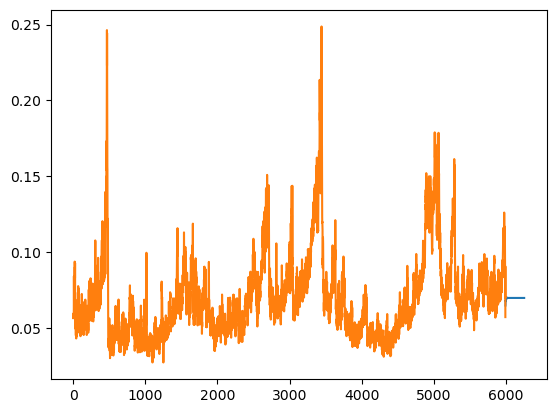

In [13]:
#Plot the prediction
plt.plot(sigma_pred)

#Plot the real valued sigma
plt.plot(real_sigma)

#Show plot
plt.show()

Although does not mirror the large variation in the real values, it does show some variation, and it certainly in the expected range of sigma, and so we use this imputation.

Then we concatenate our results together, and replace the old sigma values in the original dataframe with the new ones.

In [14]:
#Concatenate row wise the reversed forecast, putting the predictions back in order
final_sigma = pd.concat([real_sigma, sigma_pred], axis = 0)[::-1]

#Replace the column sigma in the original dataframe with the new values
aug_df['Sigma'] = final_sigma['Sigma'].values

We now inspect our augmented data-frame.

In [15]:
aug_df

,Return_with_Dividends,Return_without_Dividends,RiskFree_Rate_1Month_Forward,Return_1Month_Forward,PD_t,delta_d,Predicted R_t,Sigma
date,,,,,,,,
1998-02-07,0.304277,0.143167,0.350638,0.055277,7.095540,0.303119,0.078501,0.069727
1998-02-10,0.291903,0.154534,0.363007,0.025068,8.404637,0.303119,0.078501,0.069727
1998-02-11,0.269282,0.179072,0.365795,0.043227,13.070375,0.585262,0.078501,0.069727
1998-02-12,0.290409,0.160366,0.377143,0.056165,8.922924,-0.216997,0.078501,0.069727
1998-02-13,0.268346,0.149079,0.350271,0.074432,9.634514,0.225464,0.078501,0.069727
...,...,...,...,...,...,...,...,...
2022-02-01,0.178304,0.067787,-0.005573,-0.042527,9.661689,0.160817,-0.014614,0.056470
2022-02-02,0.194420,0.077617,0.003521,-0.039765,9.225908,0.019435,-0.037701,0.057842
2022-02-03,0.178116,0.069139,0.000203,-0.047804,9.810701,0.136210,-0.046158,0.059506


## Optimal Portfolio Allocation

To determine the optimal portfolio decision $\alpha_t (k)$, we use the fact that:

$$ \alpha_t = \frac{E_t[R_t] - R_{f,t}}{k \sigma_t^2} $$

So we can simply augment our dataframe further, carrying out this calculation. It is important to note that each value in this column must be multiplied by some $k$. For this, we will now define a new variable $\beta_t = k \alpha_t$ for a given $k$

In [16]:
#Define the Exp_R_t, R_ft and sigma_t columns
Exp_R_t = aug_df["Predicted R_t"]
R_ft = aug_df["RiskFree_Rate_1Month_Forward"]
sigma_t = aug_df["Sigma"]

#Augment a column alpha_t(k) which applies the relevant function
aug_df['beta_t'] = ((Exp_R_t - R_ft)/((sigma_t)**2)) 

Now we can generate summary statistics.

In [17]:
#Summary statistics on data
aug_df.describe()

,Return_with_Dividends,Return_without_Dividends,RiskFree_Rate_1Month_Forward,Return_1Month_Forward,PD_t,delta_d,Predicted R_t,Sigma,beta_t
count,6256.000000,6256.000000,6256.000000,6256.000000,6256.000000,6256.000000,6256.000000,6256.000000,6256.000000
mean,0.109455,-0.012911,0.130775,0.006074,8.500196,-0.017943,0.005711,0.069843,-28.034263
std,0.108956,0.096957,0.151515,0.057973,2.321165,0.249271,0.056488,0.026455,46.329467
min,-0.197034,-0.302599,-0.061559,-0.376489,4.326993,-1.404444,-0.364478,0.027157,-234.930591
25%,0.031608,-0.077261,-0.015332,-0.022522,7.013399,-0.170649,-0.020832,0.051867,-56.364743
50%,0.127174,0.005096,0.099123,0.011724,8.034640,-0.010764,0.011498,0.065440,-14.816942
75%,0.185965,0.052129,0.269003,0.040685,9.388610,0.140727,0.037303,0.078924,5.909063
max,0.406503,0.277510,0.490552,0.240728,54.194632,1.160398,0.242703,0.248792,87.805604


We observe that the mean decision is negative, which for us implies that often the equity will return a poor performance in some two asset model. Despite this, we have a comparitively large standard deviation, so there will be oppurtunities to capitalise on the equity

## Results

We now save our augmented dataframe for use in the next part

In [18]:
#Save new augmented data
aug_df.to_csv('../data/augmented_data_A3.csv')

#Save optimal portfolio decision
aug_df['beta_t'].to_csv('../data/optimal_portfolio_A3.csv')